## 🔗 Graph DB 연결하기

### 1. Aura DB

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j+s://000.databases.neo4j.io"
AUTH = ("neo4j", "<PASSWORD>")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

## 2. Sandbox : https://github.com/neo4j-graph-examples/recommendations

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j://44.197.170.109:7687"
AUTH = ("neo4j", "nineties-breaks-preservers")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [ ]:
driver = GraphDatabase.driver(URI, auth=AUTH)

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [ ]:
from collections import defaultdict

def get_schema():
    schema = ""
    with driver.session() as session:
        # 모든 노드 라벨과 속성 추출
        node_schema = session.run("""
        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes
        RETURN nodeType, propertyName, propertyTypes
        """)

        nodes = defaultdict(dict)
        for record in node_schema:
            label = record["nodeType"].replace(":", "")
            prop = record["propertyName"]
            types = record["propertyTypes"]
            nodes[label][prop] = types[0] if types else "UNKNOWN"

        # 모든 관계 타입과 속성 추출
        rel_schema = session.run("""
        CALL db.schema.relTypeProperties() YIELD relType, propertyName, propertyTypes
        RETURN relType, propertyName, propertyTypes
        """)

        relationships = defaultdict(dict)
        for record in rel_schema:
            rel = record["relType"]
            prop = record["propertyName"]
            types = record["propertyTypes"]
            relationships[rel][prop] = types[0] if types else "UNKNOWN"

        # 관계 방향 및 타입 추출
        rel_types = session.run("""
        MATCH (a)-[r]->(b)
        RETURN DISTINCT labels(a) AS from_labels, type(r) AS rel_type, labels(b) AS to_labels
        """)

        rel_directions = set()
        for record in rel_types:
            from_label = f":{record['from_labels'][0]}"
            to_label = f":{record['to_labels'][0]}"
            rel_type = record['rel_type']
            rel_directions.add(f"({from_label})-[:{rel_type}]->({to_label})")

    # 출력
    schema += "\nNode properties:\n"
    for label, props in nodes.items():
        prop_str = ", ".join(f"{k}: {v}" for k, v in props.items())
        schema += f"{label} {{{prop_str}}}\n"

    schema += "\nRelationship properties:\n"
    for rel, props in relationships.items():
        prop_str = ", ".join(f"{k}: {v}" for k, v in props.items())
        schema += f"{rel} {{{prop_str}}}\n"

    schema += "\nThe relationships:\n"
    for rel in sorted(rel_directions):
        schema += f"{rel}\n"
    return schema

schema = get_schema()

In [ ]:
print(schema)

"""
Node properties:
`Genre` {name: String}
`User` {name: String, userId: String}
`Director``Person` {name: String, imdbId: String, tmdbId: String, poster: String, born: Date, died: Date, bornIn: String, bio: String, url: String}
`Actor``Person` {name: String, imdbId: String, tmdbId: String, poster: String, born: Date, died: Date, bornIn: String, bio: String, url: String}
`Actor``Director``Person` {name: String, imdbId: String, tmdbId: String, poster: String, born: Date, died: Date, bornIn: String, bio: String, url: String}
`Movie` {movieId: String, imdbId: String, title: String, tmdbId: String, year: Long, countries: StringArray, languages: StringArray, plot: String, imdbRating: Double, imdbVotes: Long, released: String, runtime: Long, poster: String, revenue: Long, budget: Long, url: String, embedding: DoubleArray}

Relationship properties:
:`IN_GENRE` {None: UNKNOWN}
:`RATED` {rating: Double, timestamp: Long}
:`ACTED_IN` {role: String}
:`DIRECTED` {role: String}

The relationships:
(:Actor)-[:ACTED_IN]->(:Movie)
(:Actor)-[:DIRECTED]->(:Movie)
(:Director)-[:DIRECTED]->(:Movie)
(:Movie)-[:IN_GENRE]->(:Genre)
(:User)-[:RATED]->(:Movie)
"""

## 🧑‍💻 Text2Cypher 기반 GraphRAG Agent 만들기

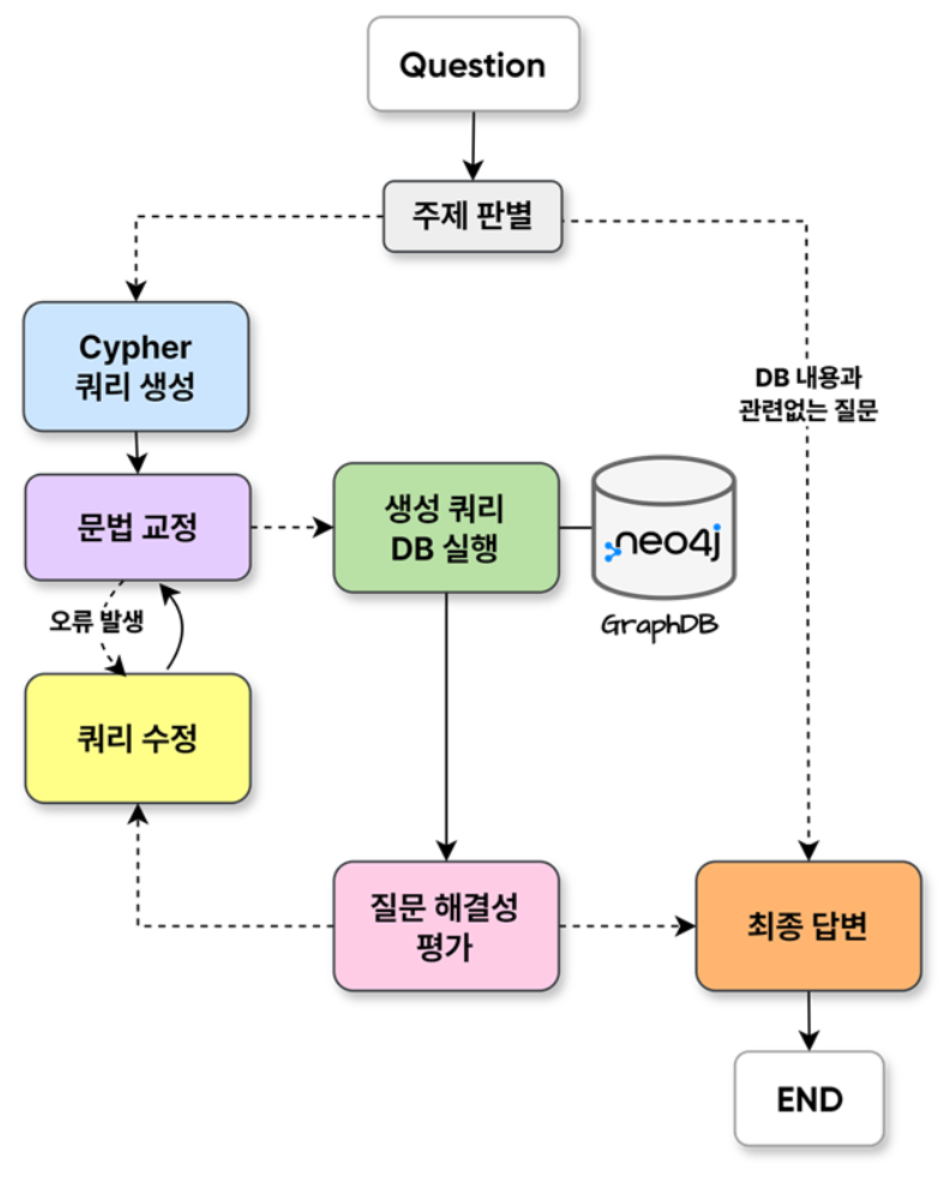

### Graph State 설정하기

In [ ]:
from operator import add
from typing import Annotated, List

from typing_extensions import TypedDict

class InputState(TypedDict):
    question: str

class OverallState(TypedDict):
    question: str # 질문
    next_action: str # 다음단계
    cypher_statement: str # Cypher 쿼리
    cypher_errors: List[str] # Cypher 쿼리 오류
    database_records: List[dict] # DB 실행결과
    steps: Annotated[List[str], add] # 그래프 실행 단계

class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

### 1) 가드레일(일반 질문 vs 영화 질문) 노드 추가

In [ ]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

guardrails_system = """
As an intelligent assistant, your primary objective is to decide whether a given question is related to movies or not.
If the question is related to movies, output "movie". Otherwise, output "end".
To make this decision, assess the content of the question and detemine if it refers to any movie, actor, director, film industry
or related topics. Provide only the specified output: "movie" or "end".
"""
guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system
        ),
        (
            "human",
            ("{question}")
        )
    ]
)

class GuardrailsOutpu(BaseModel):
    decision: Literal["movie", "end"] = Field(
        description="Decision on whether the question is ralted to movies"
    )

guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutpu)

In [ ]:
def guardrails(state: InputState) -> OverallState:
    """
    Decides if the question is reltated to movies or not.
    """
    print("---GUARDRAILS---")
    question = state["question"]
    # "end" or "movie" 리턴
    guardrails_output = guardrails_chain.invoke({"question": question})
    print("Guardrails output:", guardrails_output)

    database_records = None
    if guardrails_output.decision == "end":
        database_records = "This question is not about movies or their cast. Therefor I cannot answer this question."
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"]
    }

### 2) Text2Cypher 쿼리 생성 노드 추가

In [ ]:
examples = [
    {
        "question": "How many movies has Tom Hanks acted in?",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)"
    },
    {
        "question": "List all the genres of the movie Schindler's List",
        "query": "MATCH (m:Movie {title: 'Schindler's List'})-[:IN_GENRE]->(g:Genre) RETURN g.name"
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "query": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
]

In [ ]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        )
        (
            "human",
            (
                """You are a Noe4j expert. Given an input question, create a syntatically correct Cypher query to run.
                Do not wrap the response in any backticks or anything else. Respond with a Cypher statemnt only!
                Here is the schema information
                {schema}

                Below are a number of examples of questions and their corresponding Cypher queries.

                {fewshot_examples}

                User input: {question}
                Cypher query:
                """
            )
        )
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a Cypher statement based on the provided schema and user input.
    """
    print("---GENERATE CYPHER---")
    question = state["question"]
    fewshot_examples = str(examples)
    schema = get_schema()

    generated_cypher = text2cypher_chain.invoke(
        {
            "schema": schema,
            "fewshot_examples": fewshot_examples,
            "question": question,
        }
    )
    print("Generated Cypher:", generated_cypher)
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

### 3) 쿼리 문법 검사 노드 추가

In [ ]:
from typing import List, Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefinded variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the proerties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Example of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship Foo does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

Make sure you don't make any mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", validate_cypher_system),
        ("human", validate_cypher_user),
    ]
)

class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output, including any errors.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(ValidateCypherOutput)

In [ ]:
from neo4j.exceptions import CypherSyntaxError

def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the generated Cypher statement and maps any property values to the database.
    """
    print("---VALIDATE CYPHER---")
    errors = []

    cypher = state["cypher_statement"]

    try:
        # Explain은 실제 쿼리 실행은 아니고, 어떻게 cypher 쿼리가 실행될지 plan만 반환
        # 쿼리를 실행하지 않고 syntax 오류를 잡아낼 수 있음
        driver.execute_query(f"EXPLAIN {cypher}")
    except CypherSyntaxError as e:
        errors.append(e.message)
        print("Cypher syntax error:", e.message)

    question = state["question"]
    llm_output = validate_cypher_chain.invoke(
        {
            "schema": schema,
            "question": question,
            "cypher": cypher,
        }
    )
    print("LLM output errors:", llm_output.errors)

    if errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

### 4) 쿼리 수정 노드 추가

In [ ]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the errors provided. No pre-amble. "
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

                Schema:
                {schema}

                Note: Do not include any explanations or apologies in your response.
                Do not wrap the response in any backticks or anything else. 
                Respond with a Cypher statement only!

                Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
                
                The question is:
                {question}

                The Cypher statement is:
                {cypher}

                The errors are:
                {errors}

                Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()

def correct_cypher(state: OverallState) -> OverallState:
    """
    Corrects the Cypher statement based on the identified errors.
    """
    print("---CORRECT CYPHER---")
    question = state["question"]
    cypher = state["cypher_statement"]
    errors = state["cypher_errors"]

    corrected_cypher = correct_cypher_chain.invoke(
        {
            "schema": schema,
            "question": question,
            "cypher": cypher,
            "errors": errors,
        }
    )
    print("Corrected Cypher:", corrected_cypher)
    return {"next_action": "validate_cypher", "cypher_statement": corrected_cypher, "steps": ["correct_cypher"]}

### 5) DB 검색 노드(쿼리 실행) 추가

In [ ]:
no_results = "I could not find any relevant information in the database to answer your question."

def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """
    print("---EXECUTE CYPHER---")
    try:
        with driver.session(database="neo4j") as session:
            records = session.execute_read(lambda tx: tx.run(state["cypher_statement"]).data())
            print("Database records:", records)

    except Exception as e:
        print("Error executing Cypher:", str(e))
        records = str(e)

    print("Cypher execution results:", records)
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

### 6) 조회 결과의 관련성 평가 노드

In [ ]:
context_relevance_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are an expert assistant trained to judge whether a set of database query results "
                "provides sufficient information to answer a user's natural language question. "
                "You must make a binary decision: either the results contain enough information to fully answer the question, "
                "or they do not. Your judgment should be based strictly on the content provided in the results."
            ),
        ),
        (
            "human",
            (
                """Given the user question and the query results from a database,
                determine whether the results contain enough information to answer the question.

                Return your response with two fields:
                score: 'yes' if sufficient, 'no' if not
                    - If the results fully answer the question, respond only with "yes".
                    - If the results do not provide enough context or are incomplete, respond only with "no".
                feedback: a brief explanation of why the results are or are not sufficient

                Question:
                {question}

                Results:
                {results}
                """
            ),
        ),
    ]
)

class RelevaceScore(BaseModel):
    score: str = Field(description="Relevance score 'yes' or 'no'")
    feedback: str = Field(
        description="Feedback on the relevance of the results to the question"
    )


context_relevance_chain = context_relevance_prompt | llm.with_structured_output(RelevaceScore)

In [ ]:
def relevance(state: OverallState) -> OverallState:
    """
    Decides if the question is related to movies or not.
    """
    print("-- GRADE RELEVANCE --")
    question = state["question"]
    print(state["database_records"])
    relevance_score = context_relevance_chain.invoke({"question": question, "results": state["database_records"]})
    print("relevance score: ", relevance_score.score)
    
    if relevance_score.score == "yes":
        return {
        "next_action": "generate_final_answer",
        "database_records": state["database_records"],
        "cypher_errors" : relevance_score.feedback,
        "steps": ["relevance"],
    }
    else:
        return {
            "next_action": "correct_cypher",
            "database_records": state["database_records"],
            "cypher_errors" : relevance_score.feedback,
            "steps": ["relevance"],
        }

### 7) 답변 생성 노드

In [ ]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
                a succinct, definitive answer to the user's question.

                Respond as if you are answering the question directly.

                Results: {results}
                Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to movies.
    """
    print("-- GENERATE FINAL ANSWER --")
    question = state["question"]
    results = state["database_records"]
    print("Question:", question)
    print("Results to generate final answer from:", results)
    final_answer = generate_final_chain.invoke(
        {"question": question, "results": results}
    )
    print("Final answer:", final_answer)
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

### 8) 조건부 엣지 추가

In [ ]:
# 가드레일에서 조건부 edge > 최종 답변으로 갈지 or generate_cypher로 갈지 결정
def guardrails_condition(
    state: OverallState
) -> Literal["generate_cypher", "generate_final_answer"]:
    next_action = state["next_action"]
    if next_action == "movie":
        return "generate_cypher"
    elif next_action == "end":
        return "generate_final_answer"
    
def validate_cypher_condition(
    state: OverallState
) -> Literal["correct_cypher", "execute_cypher"]:
    next_action = state["next_action"]
    if next_action == "correct_cypher":
        return "correct_cypher"
    elif next_action == "execute_cypher":
        return "execute_cypher"

### 9) Graph Compile!

In [ ]:
from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)
graph_builder.add_node(guardrails)
graph_builder.add_node(generate_cypher)
graph_builder.add_node(validate_cypher)
graph_builder.add_node(correct_cypher)
graph_builder.add_node(execute_cypher)
graph_builder.add_node(relevance)
graph_builder.add_node(generate_final_answer)

graph_builder.add_edge(START, "guardrails")
graph_builder.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
graph_builder.add_edge("generate_cypher", "validate_cypher")
graph_builder.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)

graph_builder.add_edge("execute_cypher", "relevance")
graph_builder.add_conditional_edges(
    "relevance",
    relevance_cypher_condition,
)

graph_builder.add_edge("correct_cypher", "validate_cypher")
graph_builder.add_edge("generate_final_answer", END)

graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

테스트!

CASE 1. 일반적인 질문

In [ ]:
graph.invoke({"question": "What's the weather in Spain?"})

CASE 2. 영화 관련 질문들

In [ ]:
graph.invoke({"question": "Casino 영화에 출연한 배우들은 누구인가요?"})

In [ ]:
graph.invoke({"question": "Toy Story의 평균 평점은 얼마인가요?"})